In [1]:
from pathlib import Path

import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [2]:
data_dir = "./exp-local/data"
info_data_dir = "./exp-local/data/info"


def import_info_data(dir, pattern):
    all_files = Path(dir).glob(pattern)
    all_data = [pd.read_csv(path, index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


def import_data(dir):
    all_files = Path(dir).glob('data*.txt')
    all_data = [pd.read_fwf(path, skiprows=[1], index_col=None) for path in all_files]
    return pd.concat(all_data, axis=0, ignore_index=True)


data = import_data(data_dir)
energy = import_info_data(info_data_dir, 'perf.*.csv')
frequency = import_info_data(info_data_dir, 'cpu_freq_avg.*.csv')

data.JobName = data.JobName.replace('batch', method='ffill')
data = pd.merge(data, energy, on='JobName', how='left')
data = pd.merge(data, frequency, on='JobName', how='left')

data

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_20988\2919650027.py:21: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data.JobName = data.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,...,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,power_energy_pkg,power_energy_ram,perf_elapsed,AVG_CPU_freq_MHz
0,49404,dpp-local-nc8_gl5-37.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,212996.00,17568.28,2611.023266,1496.218926
1,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,...,NaN,NaN,NaN,NaN,NaN,NaN,212996.00,17568.28,2611.023266,1496.218926
2,49407,daa-local-nc8_gl5-38.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3170530.78,257857.42,36980.988711,1565.975350
3,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,...,NaN,NaN,NaN,NaN,NaN,NaN,3170530.78,257857.42,36980.988711,1565.975350
4,49410,dpp-local-nc4_gl5-36.cfg,gl2_gl4,NaN,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,326774.23,30665.46,4561.422457,1299.763178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,49716.batch,daa-local-nc16_ss2-11.cfg,gl2_gl4,NaN,superserver2,COMPLETED,2024-01-31T19:30:18,2024-02-01T01:31:46,NaN,3958680K,...,NaN,NaN,NaN,NaN,NaN,NaN,2227111.75,208313.77,21681.714534,2868.216187
346,49719,daa-local-nc32_ss2-13.cfg,gl2_gl4,NaN,superserver2,COMPLETED,2024-02-01T01:36:51,2024-02-01T06:22:36,NaN,NaN,...,"power/energy-pkg/,power/energy-ram/",haddock3,'daa-local-nc32_ss2-13.cfg',>,run.daa-local-nc32_ss2-13.cfg.info/haddock.out...,>,1939504.59,168686.12,17137.105646,2621.040468
347,49719.batch,daa-local-nc32_ss2-13.cfg,gl2_gl4,NaN,superserver2,COMPLETED,2024-02-01T01:36:51,2024-02-01T06:22:36,NaN,7667304K,...,NaN,NaN,NaN,NaN,NaN,NaN,1939504.59,168686.12,17137.105646,2621.040468
348,49722,daa-local-nc32_ss2-11.cfg,gl2_gl4,NaN,superserver2,COMPLETED,2024-02-01T06:27:42,2024-02-01T11:11:47,NaN,NaN,...,"power/energy-pkg/,power/energy-ram/",haddock3,'daa-local-nc32_ss2-11.cfg',>,run.daa-local-nc32_ss2-11.cfg.info/haddock.out...,>,1938673.45,167987.56,17035.742911,2621.850583


In [3]:
def convert_to_numeric(value):
    try:
        match = re.match(r'^([\d.]+)([KkMm])$', value)
        if match:
            numeric_part = float(match.group(1))
            multiplier = match.group(2).upper()

            if multiplier == 'K':
                return numeric_part * 1000
            elif multiplier == 'M':
                return numeric_part * 1000000

        return value
    except:
        return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [4]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(\w+?\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize', 'power_energy_pkg',
                   'power_energy_ram', 'AVG_CPU_freq_MHz']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}_K"] = dat[column] / 1000
        dat[f"{column}_M"] = dat[column] / 1_000_000
        dat[f"{column}_G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [5]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,power_energy_pkg_G,power_energy_ram_K,power_energy_ram_M,power_energy_ram_G,AVG_CPU_freq_MHz_K,AVG_CPU_freq_MHz_M,AVG_CPU_freq_MHz_G,ElapsedSeconds,ElapsedMinutes,ElapsedHours
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,0.005002,451.29309,0.451293,0.000451,1.359522,0.001360,0.000001,65071,1084.516667,18.075278
5,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,0.004977,448.29387,0.448294,0.000448,1.364583,0.001365,0.000001,64602,1076.700000,17.945000
11,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,0.005214,469.27201,0.469272,0.000469,1.338263,0.001338,0.000001,69122,1152.033333,19.200556
24,49494.batch,daa-local-nc4_gl5-31.cfg,gl2_gl4,gl5,COMPLETED,2024-01-25T07:19:44,2024-01-26T01:30:06,6840000.0,1.473504e+09,8.837870e+10,...,0.005015,456.26004,0.456260,0.000456,1.357146,0.001357,0.000001,65422,1090.366667,18.172778
34,49524.batch,daa-local-nc4_gl5-34.cfg,gl2_gl4,gl5,COMPLETED,2024-01-26T17:45:03,2024-01-27T11:59:53,6830000.0,1.457012e+09,8.835429e+10,...,0.005019,451.52887,0.451529,0.000452,1.364861,0.001365,0.000001,65690,1094.833333,18.247222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,48951.batch,dpp-local-nc32_gl6-39.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:30:43,2024-01-18T14:51:47,197850.0,3.898280e+09,5.341970e+09,...,0.000139,14.70329,0.014703,0.000015,NaN,NaN,NaN,1264,21.066667,0.351111
63,48969.batch,dpp-local-nc32_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:29:36,2024-01-19T06:50:34,195380.0,3.915472e+09,5.341970e+09,...,0.000138,14.25268,0.014253,0.000014,NaN,NaN,NaN,1258,20.966667,0.349444
68,48984.batch,dpp-local-nc32_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T19:38:30,2024-01-20T20:02:07,203200.0,3.947376e+09,5.345290e+09,...,0.000144,14.85122,0.014851,0.000015,NaN,NaN,NaN,1417,23.616667,0.393611
69,48990.batch,dpp-local-nc32_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:12:15,2024-01-20T20:34:20,198180.0,3.915520e+09,5.345290e+09,...,0.000140,14.48893,0.014489,0.000014,NaN,NaN,NaN,1325,22.083333,0.368056


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,SubmitLine,power_energy_pkg,power_energy_ram,perf_elapsed,AVG_CPU_freq_MHz,Workflow,mode,ncores,node,trial
0,49431,daa-local-nc4_gl5-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.daa-local-nc4_gl5-38.cfg.info/haddock.ou...,920.01,52.64,20.976121,1197.560881,daa,local,4,gl5,38
1,49434,daa-local-nc8_gl5-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.daa-local-nc8_gl5-33.cfg.info/haddock.ou...,NaN,NaN,NaN,NaN,daa,local,8,gl5,33
2,49041,daa-local-nc16_gl6-38.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc16_gl6-38.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,16,gl6,38
3,49044,daa-local-nc32_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc32_gl6-37.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,32,gl6,37
4,49053,daa-local-nc16_gl6-31.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc16_gl6-31.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,16,gl6,31
5,49056,daa-local-nc32_gl6-33.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc32_gl6-33.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,32,gl6,33
6,49059,dpp-local-nc32_gl6-35.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.dpp-local-nc32_gl6-35.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,dpp,local,32,gl6,35
7,49062,daa-local-nc8_gl6-39.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.daa-local-nc8_gl6-39.cfg.info/haddock.ou...,NaN,NaN,NaN,NaN,daa,local,8,gl6,39
8,49065,daa-local-nc16_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc16_gl6-37.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,16,gl6,37
9,49068,dpp-local-nc4_gl6-34.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.dpp-local-nc4_gl6-34.cfg.info/haddock.ou...,NaN,NaN,NaN,NaN,dpp,local,4,gl6,34


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,SubmitLine,power_energy_pkg,power_energy_ram,perf_elapsed,AVG_CPU_freq_MHz,Workflow,mode,ncores,node,trial
0,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,NaN,212996.00,17568.28,2611.023266,1496.218926,dpp,local,8,gl5,37
1,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,NaN,3170530.78,257857.42,36980.988711,1565.975350,daa,local,8,gl5,38
2,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,NaN,326774.23,30665.46,4561.422457,1299.763178,dpp,local,4,gl5,36
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6.81M,1458672K,88354.29M,...,NaN,5001768.76,451293.09,65062.053712,1359.522457,daa,local,4,gl5,32
4,49416.batch,dpp-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T00:48:59,2024-01-21T01:31:40,281.23K,1204728K,5345.28M,...,NaN,211617.75,17395.84,2559.593217,1506.578540,dpp,local,8,gl5,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,49125,dpp-local-nc8_gl6-40.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.dpp-local-nc8_gl6-40.cfg.info/haddock.ou...,NaN,NaN,NaN,NaN,dpp,local,8,gl6,40
128,49128,dpp-local-nc8_gl6-37.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,> run.dpp-local-nc8_gl6-37.cfg.info/haddock.ou...,NaN,NaN,NaN,NaN,dpp,local,8,gl6,37
129,49050,daa-local-nc32_gl6-32.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,...,run.daa-local-nc32_gl6-32.cfg.info/haddock.out...,NaN,NaN,NaN,NaN,daa,local,32,gl6,32
130,49578,dpp-local-nc32_ss2-1.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0.0,NaN,NaN,...,run.dpp-local-nc32_ss2-1.cfg.info/haddock.outp...,787.12,70.71,16.624636,3155.532352,dpp,local,32,ss2,1


In [6]:
data = data.dropna(subset=['AveCPU'])

data['n_ave_cpu'] = data['AveCPU'].apply(convert_elapsed_time)
data['n_elapsed'] = data['Elapsed'].apply(convert_elapsed_time)
data['cpu_utilization'] = data['n_ave_cpu'] / data['n_elapsed']

data_completed = data_completed.dropna(subset=['AveCPU'])
data_completed['n_ave_cpu'] = data_completed['AveCPU'].apply(convert_elapsed_time)
data_completed['n_elapsed'] = data_completed['Elapsed'].apply(convert_elapsed_time)
data_completed['cpu_utilization'] = data_completed['n_ave_cpu'] / data_completed['n_elapsed']

display(data, data_completed)

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,perf_elapsed,AVG_CPU_freq_MHz,Workflow,mode,ncores,node,trial,n_ave_cpu,n_elapsed,cpu_utilization
0,49404.batch,dpp-local-nc8_gl5-37.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:08:03,2024-01-19T18:51:36,283.30K,1184184K,5342.08M,...,2611.023266,1496.218926,dpp,local,8,gl5,37,17247,2613,6.600459
1,49407.batch,daa-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-19T18:56:40,2024-01-20T05:13:13,4.20M,2618236K,88378.70M,...,36980.988711,1565.975350,daa,local,8,gl5,38,252844,36993,6.834915
2,49410.batch,dpp-local-nc4_gl5-36.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T05:18:16,2024-01-20T06:34:20,449.46K,693064K,5345.29M,...,4561.422457,1299.763178,dpp,local,4,gl5,36,15875,4564,3.478309
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6.81M,1458672K,88354.29M,...,65062.053712,1359.522457,daa,local,4,gl5,32,225582,65071,3.466706
4,49416.batch,dpp-local-nc8_gl5-38.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T00:48:59,2024-01-21T01:31:40,281.23K,1204728K,5345.28M,...,2559.593217,1506.578540,dpp,local,8,gl5,38,17227,2561,6.726669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,49689.batch,daa-local-nc16_gl6-43.cfg,gl2_gl4,gl6,COMPLETED,2024-01-31T08:58:27,2024-01-31T15:07:42,3.28M,4909472K,88378.76M,...,22145.934288,1817.880487,daa,local,16,gl6,43,286715,22155,12.941323
95,49692.batch,daa-local-nc32_gl6-42.cfg,gl2_gl4,gl6,COMPLETED,2024-01-31T15:12:47,2024-01-31T19:59:39,2.75M,9514128K,88378.76M,...,17201.990459,2268.899112,daa,local,32,gl6,42,434405,17212,25.238496
96,49695.batch,daa-local-nc16_gl6-41.cfg,gl2_gl4,gl6,COMPLETED,2024-01-31T20:04:42,2024-02-01T02:13:35,3.27M,4909036K,88378.76M,...,22122.744461,1833.467460,daa,local,16,gl6,41,287427,22133,12.986355
97,49698.batch,daa-local-nc32_gl6-41.cfg,gl2_gl4,gl6,COMPLETED,2024-02-01T02:18:39,2024-02-01T07:09:10,2.77M,9480864K,88359.16M,...,17422.486770,2253.098164,daa,local,32,gl6,41,433746,17431,24.883598


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,power_energy_ram_G,AVG_CPU_freq_MHz_K,AVG_CPU_freq_MHz_M,AVG_CPU_freq_MHz_G,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_ave_cpu,n_elapsed,cpu_utilization
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,0.000451,1.359522,0.001360,0.000001,65071,1084.516667,18.075278,225582,65071,3.466706
5,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,0.000448,1.364583,0.001365,0.000001,64602,1076.700000,17.945000,224956,64602,3.482183
11,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,0.000469,1.338263,0.001338,0.000001,69122,1152.033333,19.200556,226267,69122,3.273444
24,49494.batch,daa-local-nc4_gl5-31.cfg,gl2_gl4,gl5,COMPLETED,2024-01-25T07:19:44,2024-01-26T01:30:06,6840000.0,1.473504e+09,8.837870e+10,...,0.000456,1.357146,0.001357,0.000001,65422,1090.366667,18.172778,225263,65422,3.443230
34,49524.batch,daa-local-nc4_gl5-34.cfg,gl2_gl4,gl5,COMPLETED,2024-01-26T17:45:03,2024-01-27T11:59:53,6830000.0,1.457012e+09,8.835429e+10,...,0.000452,1.364861,0.001365,0.000001,65690,1094.833333,18.247222,225808,65690,3.437479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,48951.batch,dpp-local-nc32_gl6-39.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:30:43,2024-01-18T14:51:47,197850.0,3.898280e+09,5.341970e+09,...,0.000015,NaN,NaN,NaN,1264,21.066667,0.351111,28686,1264,22.694620
63,48969.batch,dpp-local-nc32_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:29:36,2024-01-19T06:50:34,195380.0,3.915472e+09,5.341970e+09,...,0.000014,NaN,NaN,NaN,1258,20.966667,0.349444,28256,1258,22.461049
68,48984.batch,dpp-local-nc32_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T19:38:30,2024-01-20T20:02:07,203200.0,3.947376e+09,5.345290e+09,...,0.000015,NaN,NaN,NaN,1417,23.616667,0.393611,27913,1417,19.698659
69,48990.batch,dpp-local-nc32_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:12:15,2024-01-20T20:34:20,198180.0,3.915520e+09,5.345290e+09,...,0.000014,NaN,NaN,NaN,1325,22.083333,0.368056,28146,1325,21.242264


In [7]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                               \
                                        count          mean            std   
0       daa  local      4  gl5            6.0  6.853333e+06  119107.794315   
1       daa  local      4  gl6            6.0  7.603333e+06   40824.829046   
2       daa  local      8  gl5            7.0  4.268571e+06  101230.524288   
3       daa  local      8  gl6            7.0  4.757143e+06   21380.899353   
4       daa  local     16  gl5            3.0  2.863333e+06   11547.005384   
5       daa  local     16  gl6            7.0  3.250000e+06   40824.829046   
6       daa  local     32  gl5            3.0  2.480000e+06   17320.508076   
7       daa  local     32  gl6            8.0  2.738750e+06   35228.843702   
8       dpp  local      4  gl5            8.0  4.644225e+05   16755.551532   
9       dpp  local      4  gl6            5.0  5.280560e+05   27846.481465   
10      dpp  local      8  gl5            9.0  2.864344e+05    7279.514254   
11      dpp  local      8  gl6            7.0  3.235414e+05    3456.893734   
12      dpp  local     16  gl5            4.0  2.070225e+05    9028.161035   
13      dpp  local     16  gl6            6.0  2.301450e+05     827.882842   
14      dpp  local     32  gl5            6.0  1.777717e+05    2471.723420   
15      dpp  local     32  gl6            7.0  1.987886e+05    2467.214547   

                                     ... n_elapsed          cpu_utilization  \
          min        25%        50%  ...       75%      max           count   
0   6770000.0  6787500.0  6820000.0  ...  65623.00  69122.0             6.0   
1   7540000.0  7582500.0  7610000.0  ...  62674.00  62696.0             6.0   
2   4190000.0  4205000.0  4210000.0  ...  38442.50  39658.0             7.0   
3   4730000.0  4750000.0  4750000.0  ...  35723.50  36034.0             7.0   
4   2850000.0  2860000.0  2870000.0  ...  22501.50  22526.0             3.0   
5   3200000.0  3215000.0  3260000.0  ...  22157.50  22599.0             7.0   
6   2460000.0  2475000.0  2490000.0  ...  17758.50  17823.0             3.0   
7   2700000.0  2700000.0  2745000.0  ...  17483.75  17874.0             8.0   
8    447040.0   449565.0   462120.0  ...   5372.00   5698.0             8.0   
9    513660.0   514220.0   516680.0  ...   4457.00   5546.0             5.0   
10   281230.0   282850.0   283080.0  ...   2613.00   2972.0             9.0   
11   318590.0   321790.0   323240.0  ...   2529.50   2593.0             7.0   
12   198510.0   199590.0   207110.0  ...   1910.00   1943.0             4.0   
13   229190.0   229475.0   230120.0  ...   1607.00   1646.0             6.0   
14   176320.0   176497.5   176865.0  ...   1338.25   1395.0             6.0   
15   195380.0   197635.0   198180.0  ...   1327.50   1417.0             7.0   

                                                                                
         mean       std        min        25%        50%        75%        max  
0    3.428561  0.077804   3.273444   3.438917   3.454968   3.467919   3.482183  
1    3.599984  0.035407   3.565816   3.572456   3.588855   3.627678   3.648767  
2    6.718555  0.223097   6.396684   6.584992   6.831091   6.855376   6.921374  
3    7.061403  0.075320   6.993034   7.001838   7.009267   7.134846   7.154155  
4   12.741740  0.144190  12.648495  12.658701  12.668906  12.788362  12.907818  
5   13.095259  0.265974  12.656843  12.963839  13.035785  13.342591  13.361327  
6   24.656632  0.304553  24.405375  24.487276  24.569176  24.782260  24.995345  
7   25.411266  0.785488  24.331599  24.815629  25.332369  26.207897  26.352207  
8    3.241115  0.262699   2.843278   3.015502   3.309137   3.474590   3.493920  
9    3.356567  0.305042   2.815723   3.438411   3.481906   3.494952   3.551843  
10   6.504733  0.324049   5.835128   6.600459   6.636994   6.677494   6.726669  
11   6.685265  0.126402   6.453529   6.638175   6.723944   6.765240   6.812550  
12  11.118259  1.004300  10.148739  10.31

In [8]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    n_trials=('trial', 'count'), trials_list=('trial', lambda x: sorted(x.tolist()))).reset_index()
collected_data.to_csv('local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,n_trials,trials_list
0,daa,local,4,gl5,6,"[31, 32, 33, 34, 35, 37]"
1,daa,local,4,gl6,6,"[31, 32, 33, 36, 37, 40]"
2,daa,local,8,gl5,7,"[31, 32, 34, 35, 36, 37, 38]"
3,daa,local,8,gl6,7,"[31, 32, 33, 34, 36, 38, 40]"
4,daa,local,16,gl5,3,"[41, 42, 43]"
5,daa,local,16,gl6,7,"[32, 33, 35, 36, 41, 42, 43]"
6,daa,local,32,gl5,3,"[41, 42, 43]"
7,daa,local,32,gl6,8,"[34, 35, 36, 38, 40, 41, 42, 43]"
8,dpp,local,4,gl5,8,"[32, 33, 34, 35, 36, 37, 38, 39]"
9,dpp,local,4,gl6,5,"[31, 35, 36, 38, 39]"


In [9]:
# All collected data
collected_data = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores']).agg(
    n_trials=('trial', 'count')).reset_index()
collected_data.to_csv('total_local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,n_trials
0,daa,local,4,12
1,daa,local,8,14
2,daa,local,16,10
3,daa,local,32,11
4,dpp,local,4,13
5,dpp,local,8,16
6,dpp,local,16,10
7,dpp,local,32,13


In [10]:
def to_local_config_class(workflow, node, trial, ncores, warmup=False):
    warmup_arg = ", True" if warmup else ""
    return f'LocalConfig("{workflow}", "{node}", {trial}, {ncores}{warmup_arg})'


def to_configs_array(x, start_idx, node):
    return f'[{to_local_config_class(x.Workflow, node if node else x.node, "trial", x.ncores)} for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]'


def max_ncores(node):
    if node == 'gl2':
        return 8
    return 32


def get_configs_code_for_new_experiment(node, data_of_node, target_total_n, start_idx):
    exp_data = collected_data[(collected_data.node == data_of_node) & (
            collected_data.n_trials < target_total_n)]
    exp_data['trials_left_count'] = target_total_n - exp_data.n_trials
    exp_data['code'] = exp_data.apply(to_configs_array, axis=1, start_idx=start_idx, node=node)
    return " + ".join(exp_data.code.to_list()), to_local_config_class('dpp', node, start_idx,
                                                                      max_ncores(node), warmup=True)

In [11]:
TOTAL_EXPERIMENTS_PER_EPOCH = 10


def get_class_name(node, epoch):
    return f"{node.upper()}_{epoch}"


def generate_class(node, epoch, target_total_n, data_of_node):
    configs, warmup_config = get_configs_code_for_new_experiment(node, data_of_node, target_total_n,
                                                                 (epoch - 1) * TOTAL_EXPERIMENTS_PER_EPOCH + 1)
    class_definition = \
        f"""
from typing import List

from examples.domain import LocalExperiment
from examples.domain.config.Config import Config
from examples.domain.config.LocalConfig import LocalConfig

class {get_class_name(node, epoch)}(LocalExperiment):
    def create_configs(self) -> List[Config]:
        return {configs}

    def create_warmup_config(self) -> Config:
        return {warmup_config}
"""
    return class_definition if configs else None

In [12]:
# new experiment epochs
def generate_experiment_classes(exp_epochs, data_of_node: str):
    for node, epoch in exp_epochs.items():
        class_code = generate_class(node, epoch, TOTAL_EXPERIMENTS_PER_EPOCH, data_of_node)
        if class_code is None:
            continue

        file_path = f"../examples/domain/experiment/local/{get_class_name(node, epoch)}.py"
        with open(file_path, 'w') as file:
            file.write(class_code)

# generate_experiment_classes({
#     # "gl2": 3,
#     # "gl6": 3,
#     "gl5": 3
# }, data_of_node="gl6")

In [13]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AVG_CPU_freq_MHz_M,AVG_CPU_freq_MHz_G,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_ave_cpu,n_elapsed,cpu_utilization,n_trials_completed,n_trials_threshold
3,49413.batch,daa-local-nc4_gl5-32.cfg,gl2_gl4,gl5,COMPLETED,2024-01-20T06:39:24,2024-01-21T00:43:55,6810000.0,1.458672e+09,8.835429e+10,...,0.001360,0.000001,65071,1084.516667,18.075278,225582,65071,3.466706,6,True
5,49419.batch,daa-local-nc4_gl5-35.cfg,gl2_gl4,gl5,COMPLETED,2024-01-21T01:36:44,2024-01-21T19:33:26,6770000.0,1.480084e+09,8.835445e+10,...,0.001365,0.000001,64602,1076.700000,17.945000,224956,64602,3.482183,6,True
11,49452.batch,daa-local-nc4_gl5-33.cfg,gl2_gl4,gl5,COMPLETED,2024-01-22T16:44:12,2024-01-23T11:56:14,7090000.0,1.456736e+09,8.837870e+10,...,0.001338,0.000001,69122,1152.033333,19.200556,226267,69122,3.273444,6,True
24,49494.batch,daa-local-nc4_gl5-31.cfg,gl2_gl4,gl5,COMPLETED,2024-01-25T07:19:44,2024-01-26T01:30:06,6840000.0,1.473504e+09,8.837870e+10,...,0.001357,0.000001,65422,1090.366667,18.172778,225263,65422,3.443230,6,True
34,49524.batch,daa-local-nc4_gl5-34.cfg,gl2_gl4,gl5,COMPLETED,2024-01-26T17:45:03,2024-01-27T11:59:53,6830000.0,1.457012e+09,8.835429e+10,...,0.001365,0.000001,65690,1094.833333,18.247222,225808,65690,3.437479,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,48951.batch,dpp-local-nc32_gl6-39.cfg,gl2_gl4,gl6,COMPLETED,2024-01-18T14:30:43,2024-01-18T14:51:47,197850.0,3.898280e+09,5.341970e+09,...,NaN,NaN,1264,21.066667,0.351111,28686,1264,22.694620,7,True
63,48969.batch,dpp-local-nc32_gl6-38.cfg,gl2_gl4,gl6,COMPLETED,2024-01-19T06:29:36,2024-01-19T06:50:34,195380.0,3.915472e+09,5.341970e+09,...,NaN,NaN,1258,20.966667,0.349444,28256,1258,22.461049,7,True
68,48984.batch,dpp-local-nc32_gl6-40.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T19:38:30,2024-01-20T20:02:07,203200.0,3.947376e+09,5.345290e+09,...,NaN,NaN,1417,23.616667,0.393611,27913,1417,19.698659,7,True
69,48990.batch,dpp-local-nc32_gl6-32.cfg,gl2_gl4,gl6,COMPLETED,2024-01-20T20:12:15,2024-01-20T20:34:20,198180.0,3.915520e+09,5.345290e+09,...,NaN,NaN,1325,22.083333,0.368056,28146,1325,21.242264,7,True


In [14]:
import matplotlib.pyplot as plt

In [15]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

[Text(1, 0, '(daa, 4, gl5)'),
 Text(2, 0, '(daa, 4, gl6)'),
 Text(3, 0, '(daa, 8, gl5)'),
 Text(4, 0, '(daa, 8, gl6)'),
 Text(5, 0, '(daa, 16, gl5)'),
 Text(6, 0, '(daa, 16, gl6)'),
 Text(7, 0, '(daa, 32, gl5)'),
 Text(8, 0, '(daa, 32, gl6)'),
 Text(9, 0, '(dpp, 4, gl5)'),
 Text(10, 0, '(dpp, 4, gl6)'),
 Text(11, 0, '(dpp, 8, gl5)'),
 Text(12, 0, '(dpp, 8, gl6)'),
 Text(13, 0, '(dpp, 16, gl5)'),
 Text(14, 0, '(dpp, 16, gl6)'),
 Text(15, 0, '(dpp, 32, gl5)'),
 Text(16, 0, '(dpp, 32, gl6)')]

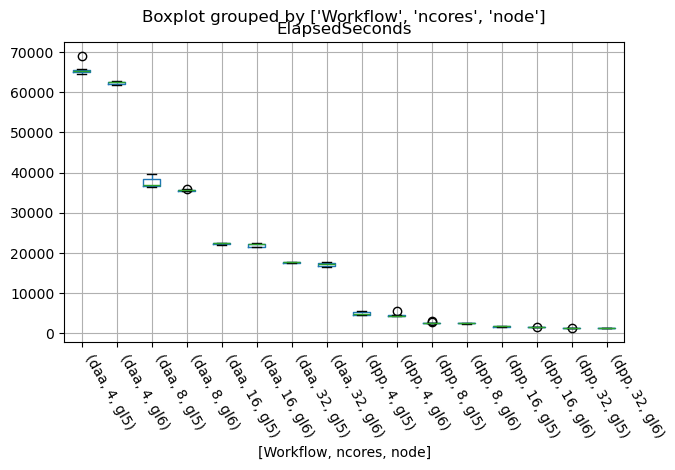

In [16]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(7, 4))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60, ha="left")
# save
# fig.savefig('boxplot.png')


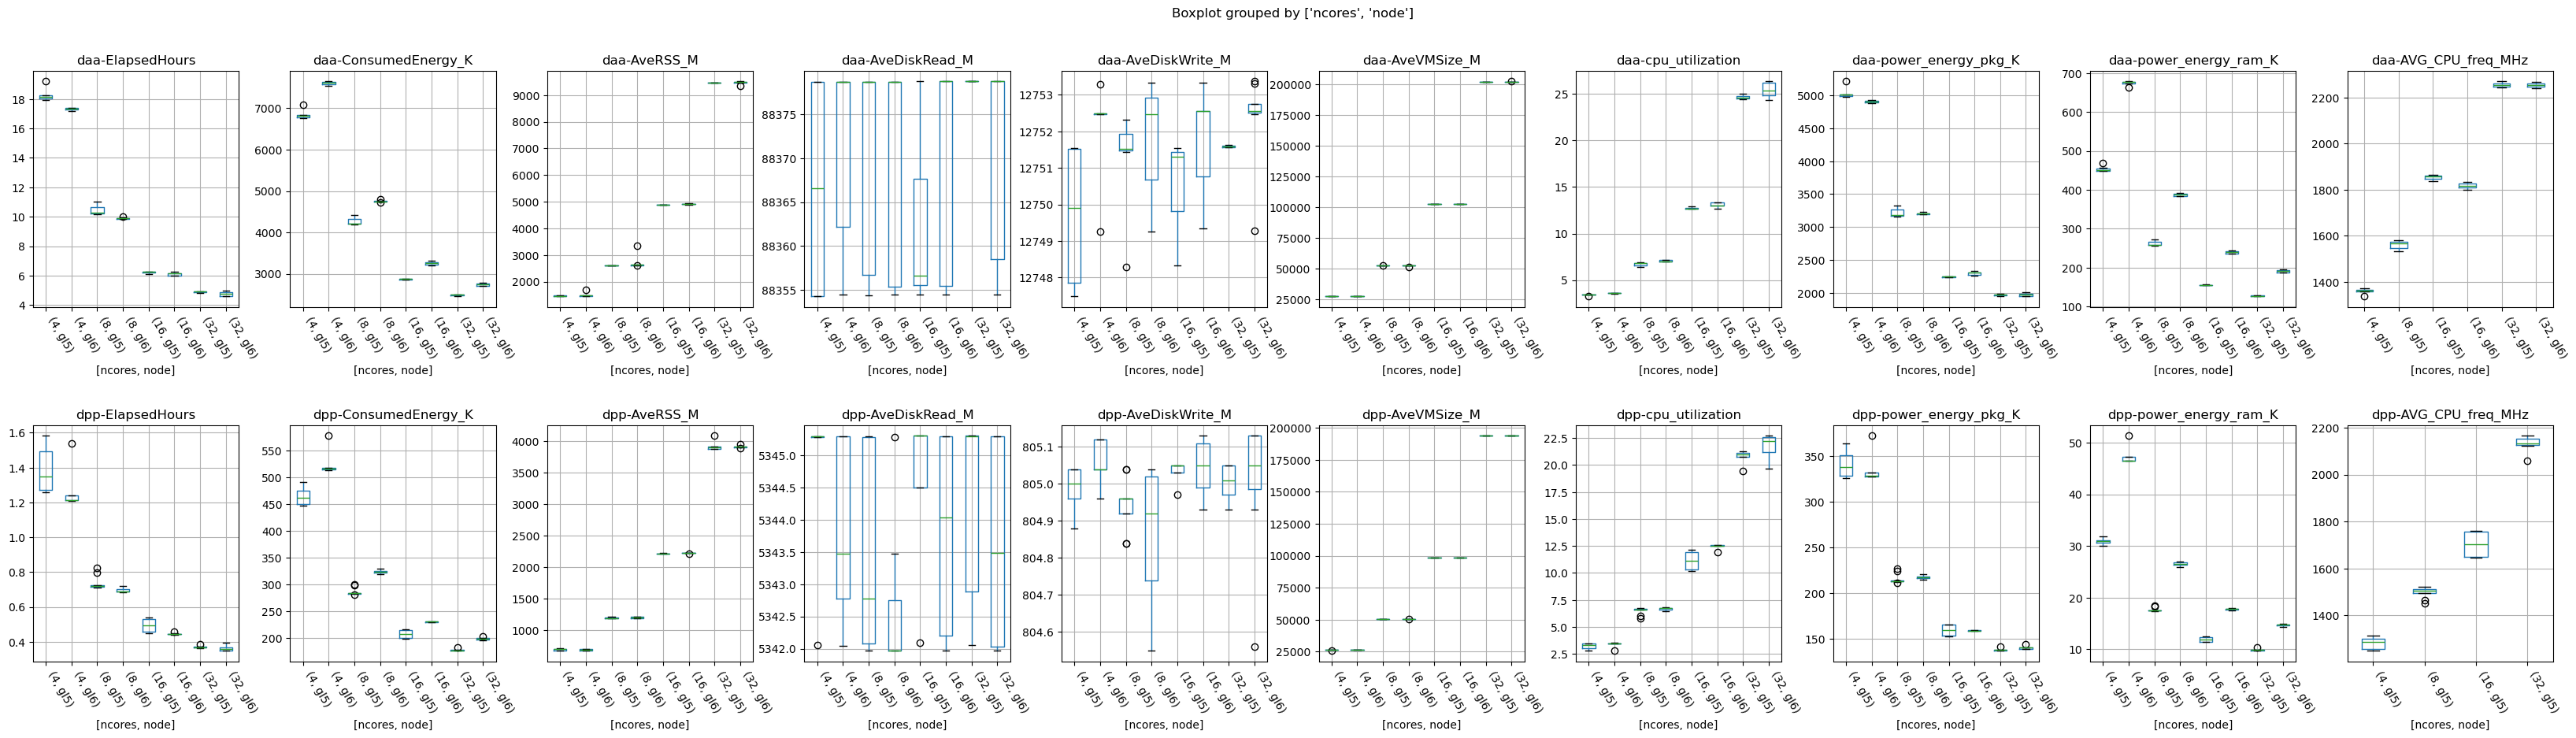

In [17]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
columns_to_plot = ['ElapsedHours', 'ConsumedEnergy_K', 'AveRSS_M', 'AveDiskRead_M', 'AveDiskWrite_M', 'AveVMSize_M',
                   'cpu_utilization', 'power_energy_pkg_K', 'power_energy_ram_K', 'AVG_CPU_freq_MHz']
nrows = 2
ncols = len(columns_to_plot)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(columns_to_plot):
        data_for_analysis[data_for_analysis.Workflow == workflow].dropna(subset=column).boxplot(column=column,
                                                                                                by=['ncores', 'node'],
                                                                                                ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60, ha="left")
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('boxplot-overview-by-workflows.png')

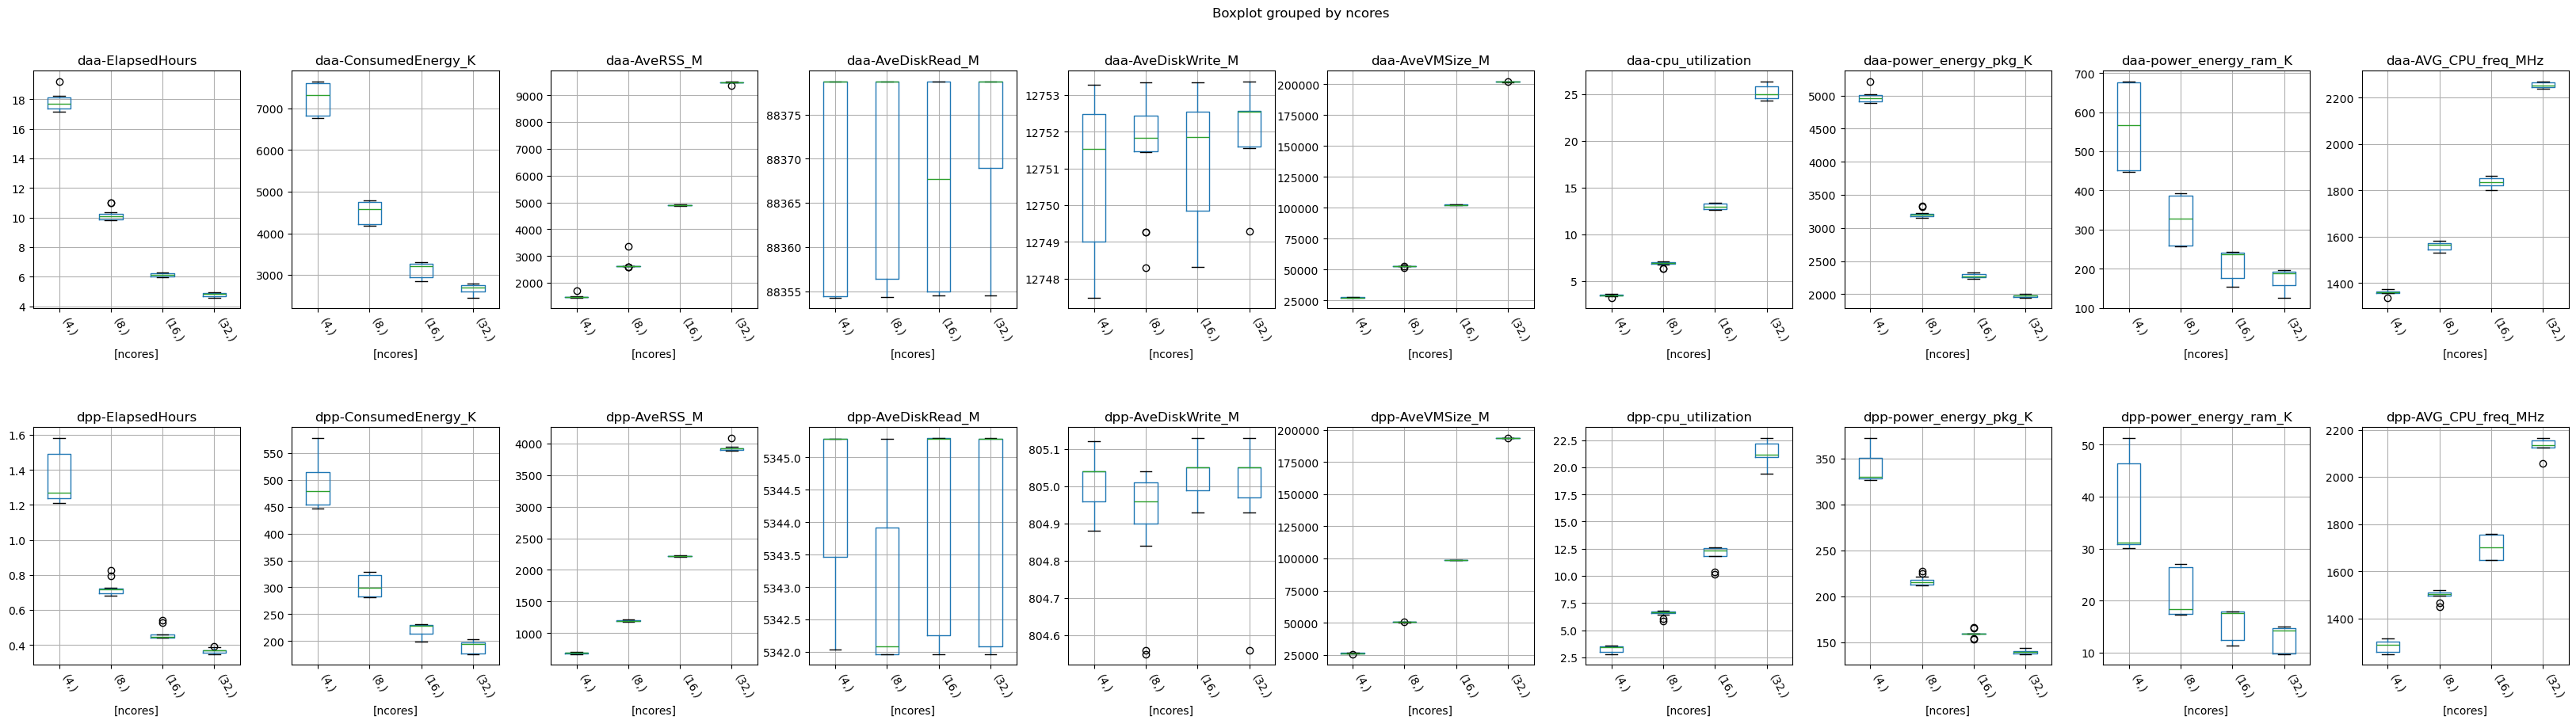

In [18]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
columns_to_plot = ['ElapsedHours', 'ConsumedEnergy_K', 'AveRSS_M', 'AveDiskRead_M', 'AveDiskWrite_M', 'AveVMSize_M',
                   'cpu_utilization', 'power_energy_pkg_K', 'power_energy_ram_K', 'AVG_CPU_freq_MHz']
nrows = 2
ncols = len(columns_to_plot)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(columns_to_plot):
        data_for_analysis[data_for_analysis.Workflow == workflow].dropna(subset=column).boxplot(column=column,
                                                                                                by=['ncores'],
                                                                                                ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60, ha="left")
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('boxplot-overview-by-workflows.no-nodes.png')

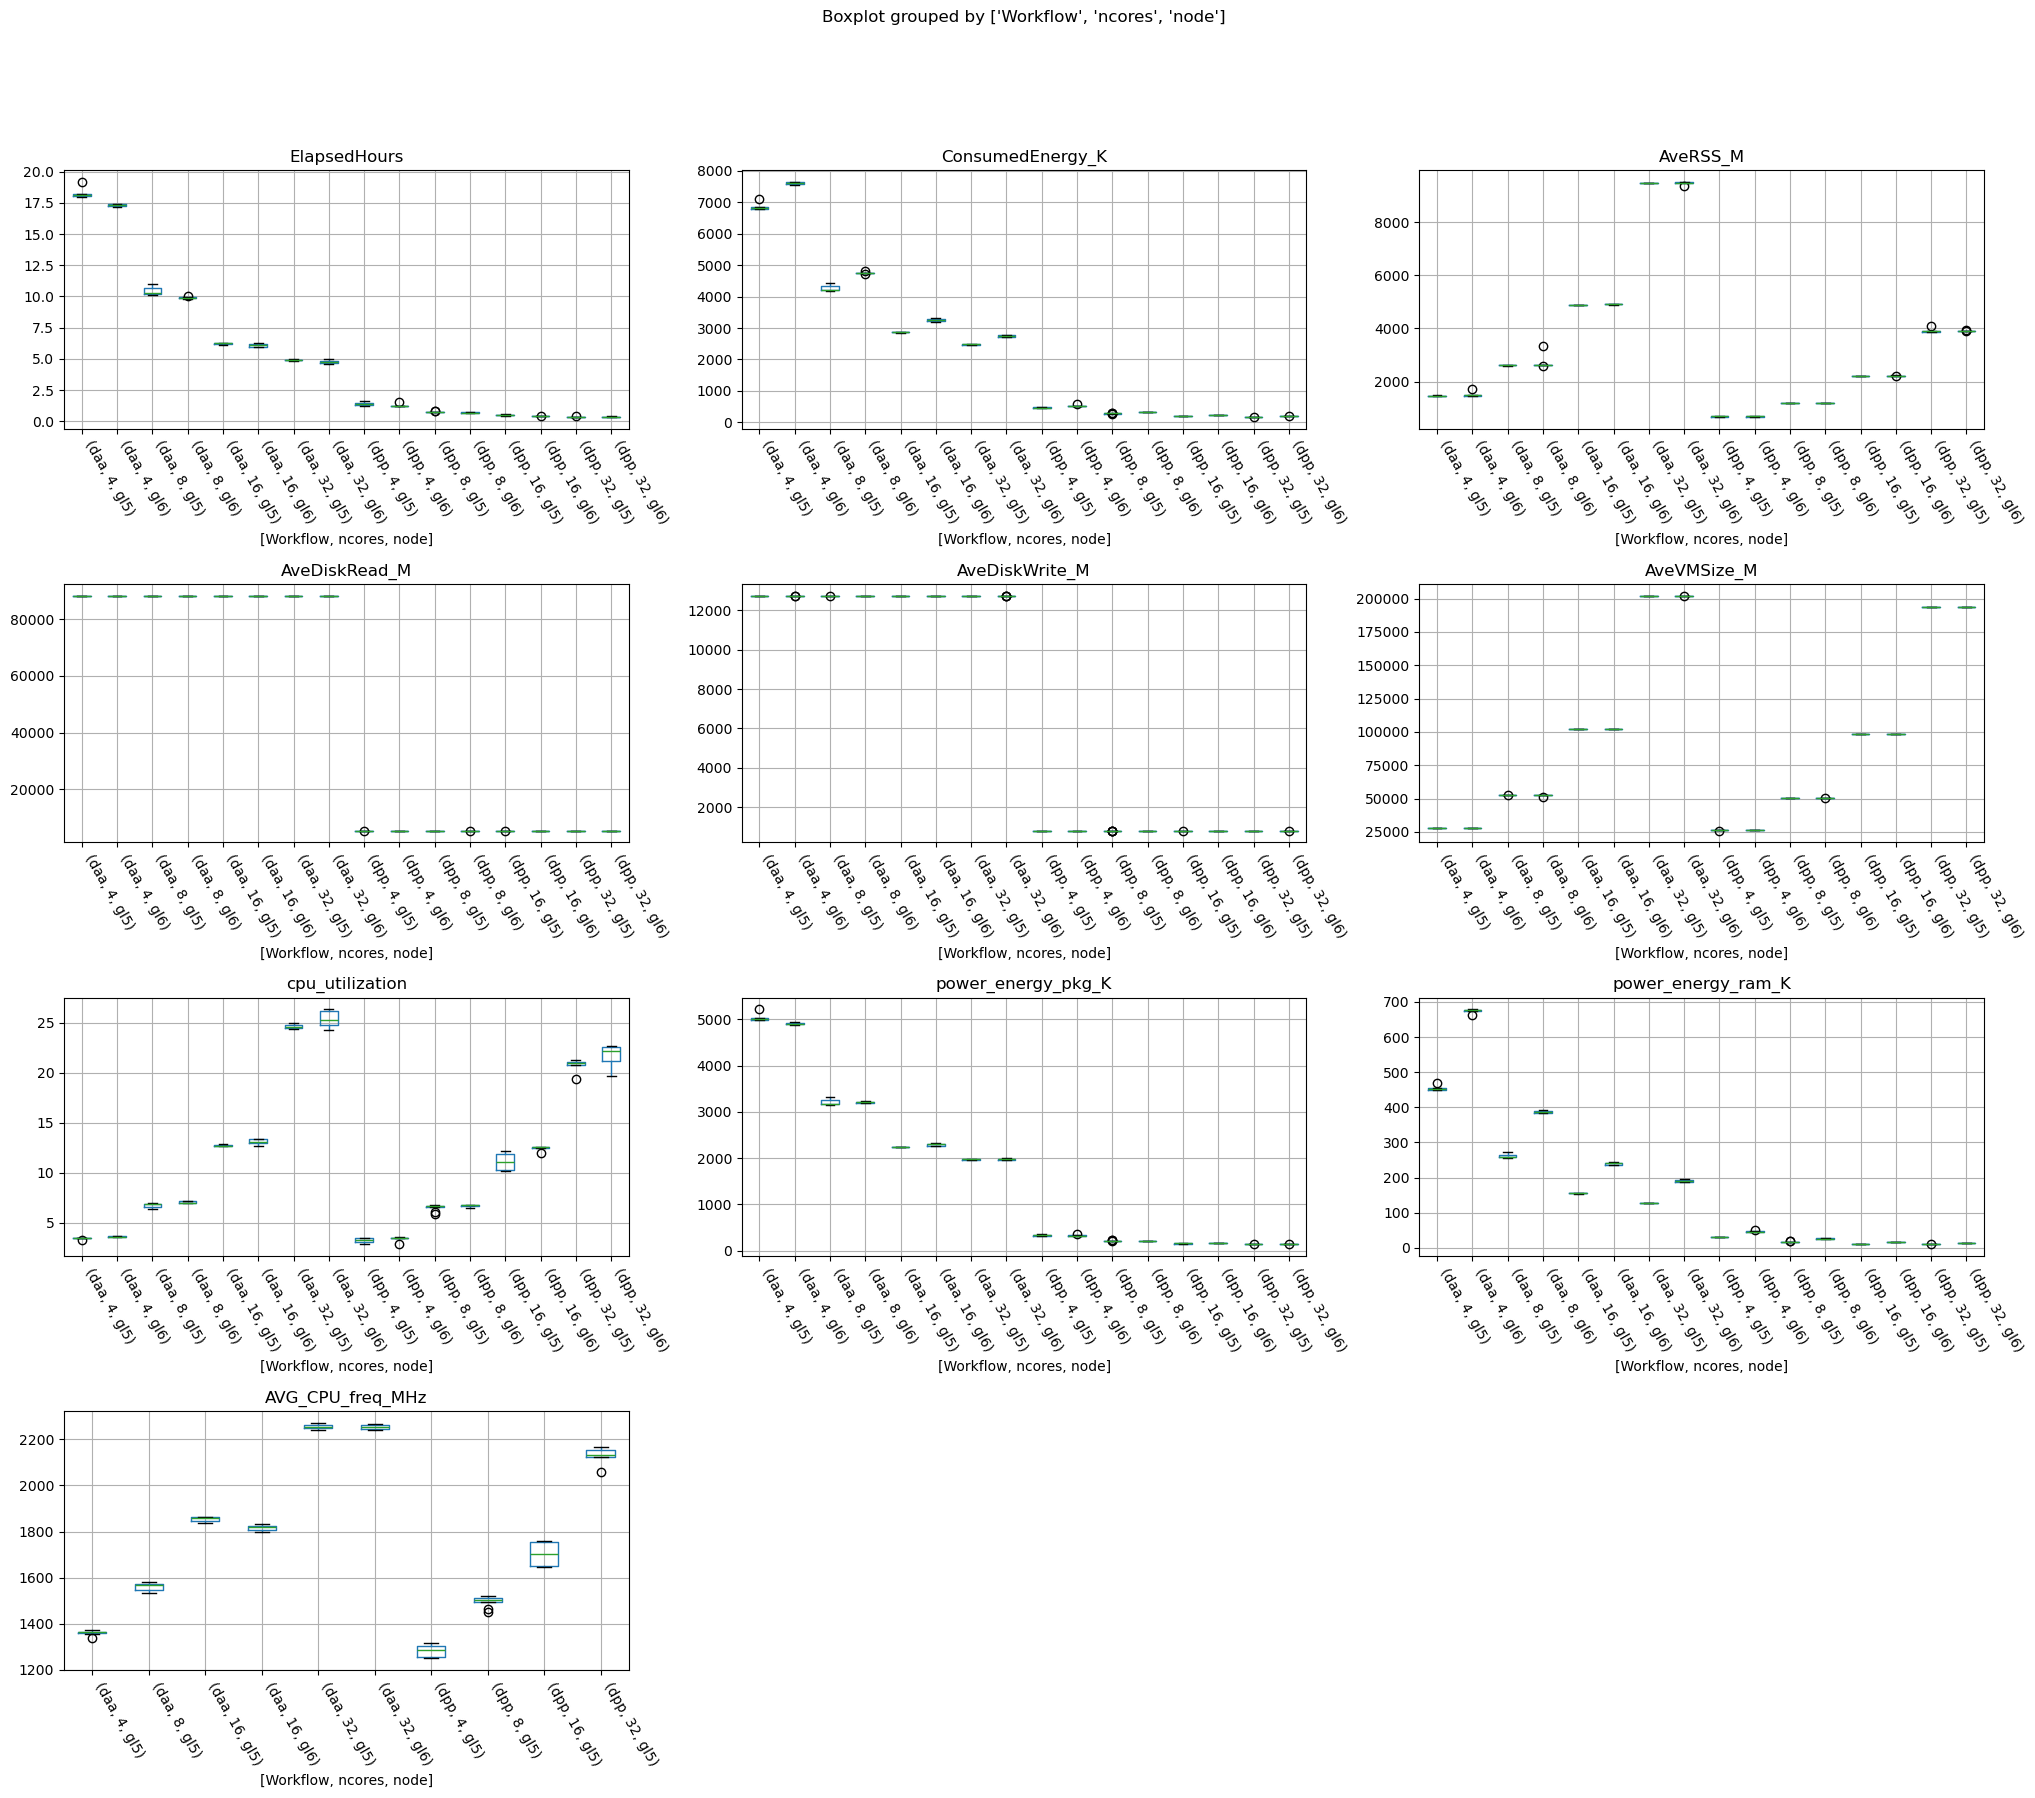

In [19]:
import math

ncols = 3
nrows = math.ceil(len(columns_to_plot) / ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 5))
for i, column in enumerate(
        columns_to_plot):
    data_for_analysis.dropna(subset=column).boxplot(column=column, by=['Workflow', 'ncores', 'node'],
                                                    ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60, ha="left")

if len(columns_to_plot) < ncols * nrows:
    for i in range(len(columns_to_plot), ncols * nrows):
        ax[i // 3, i % 3].axis('off')

fig.subplots_adjust(hspace=0.6)

fig.savefig('boxplot-overview.png')

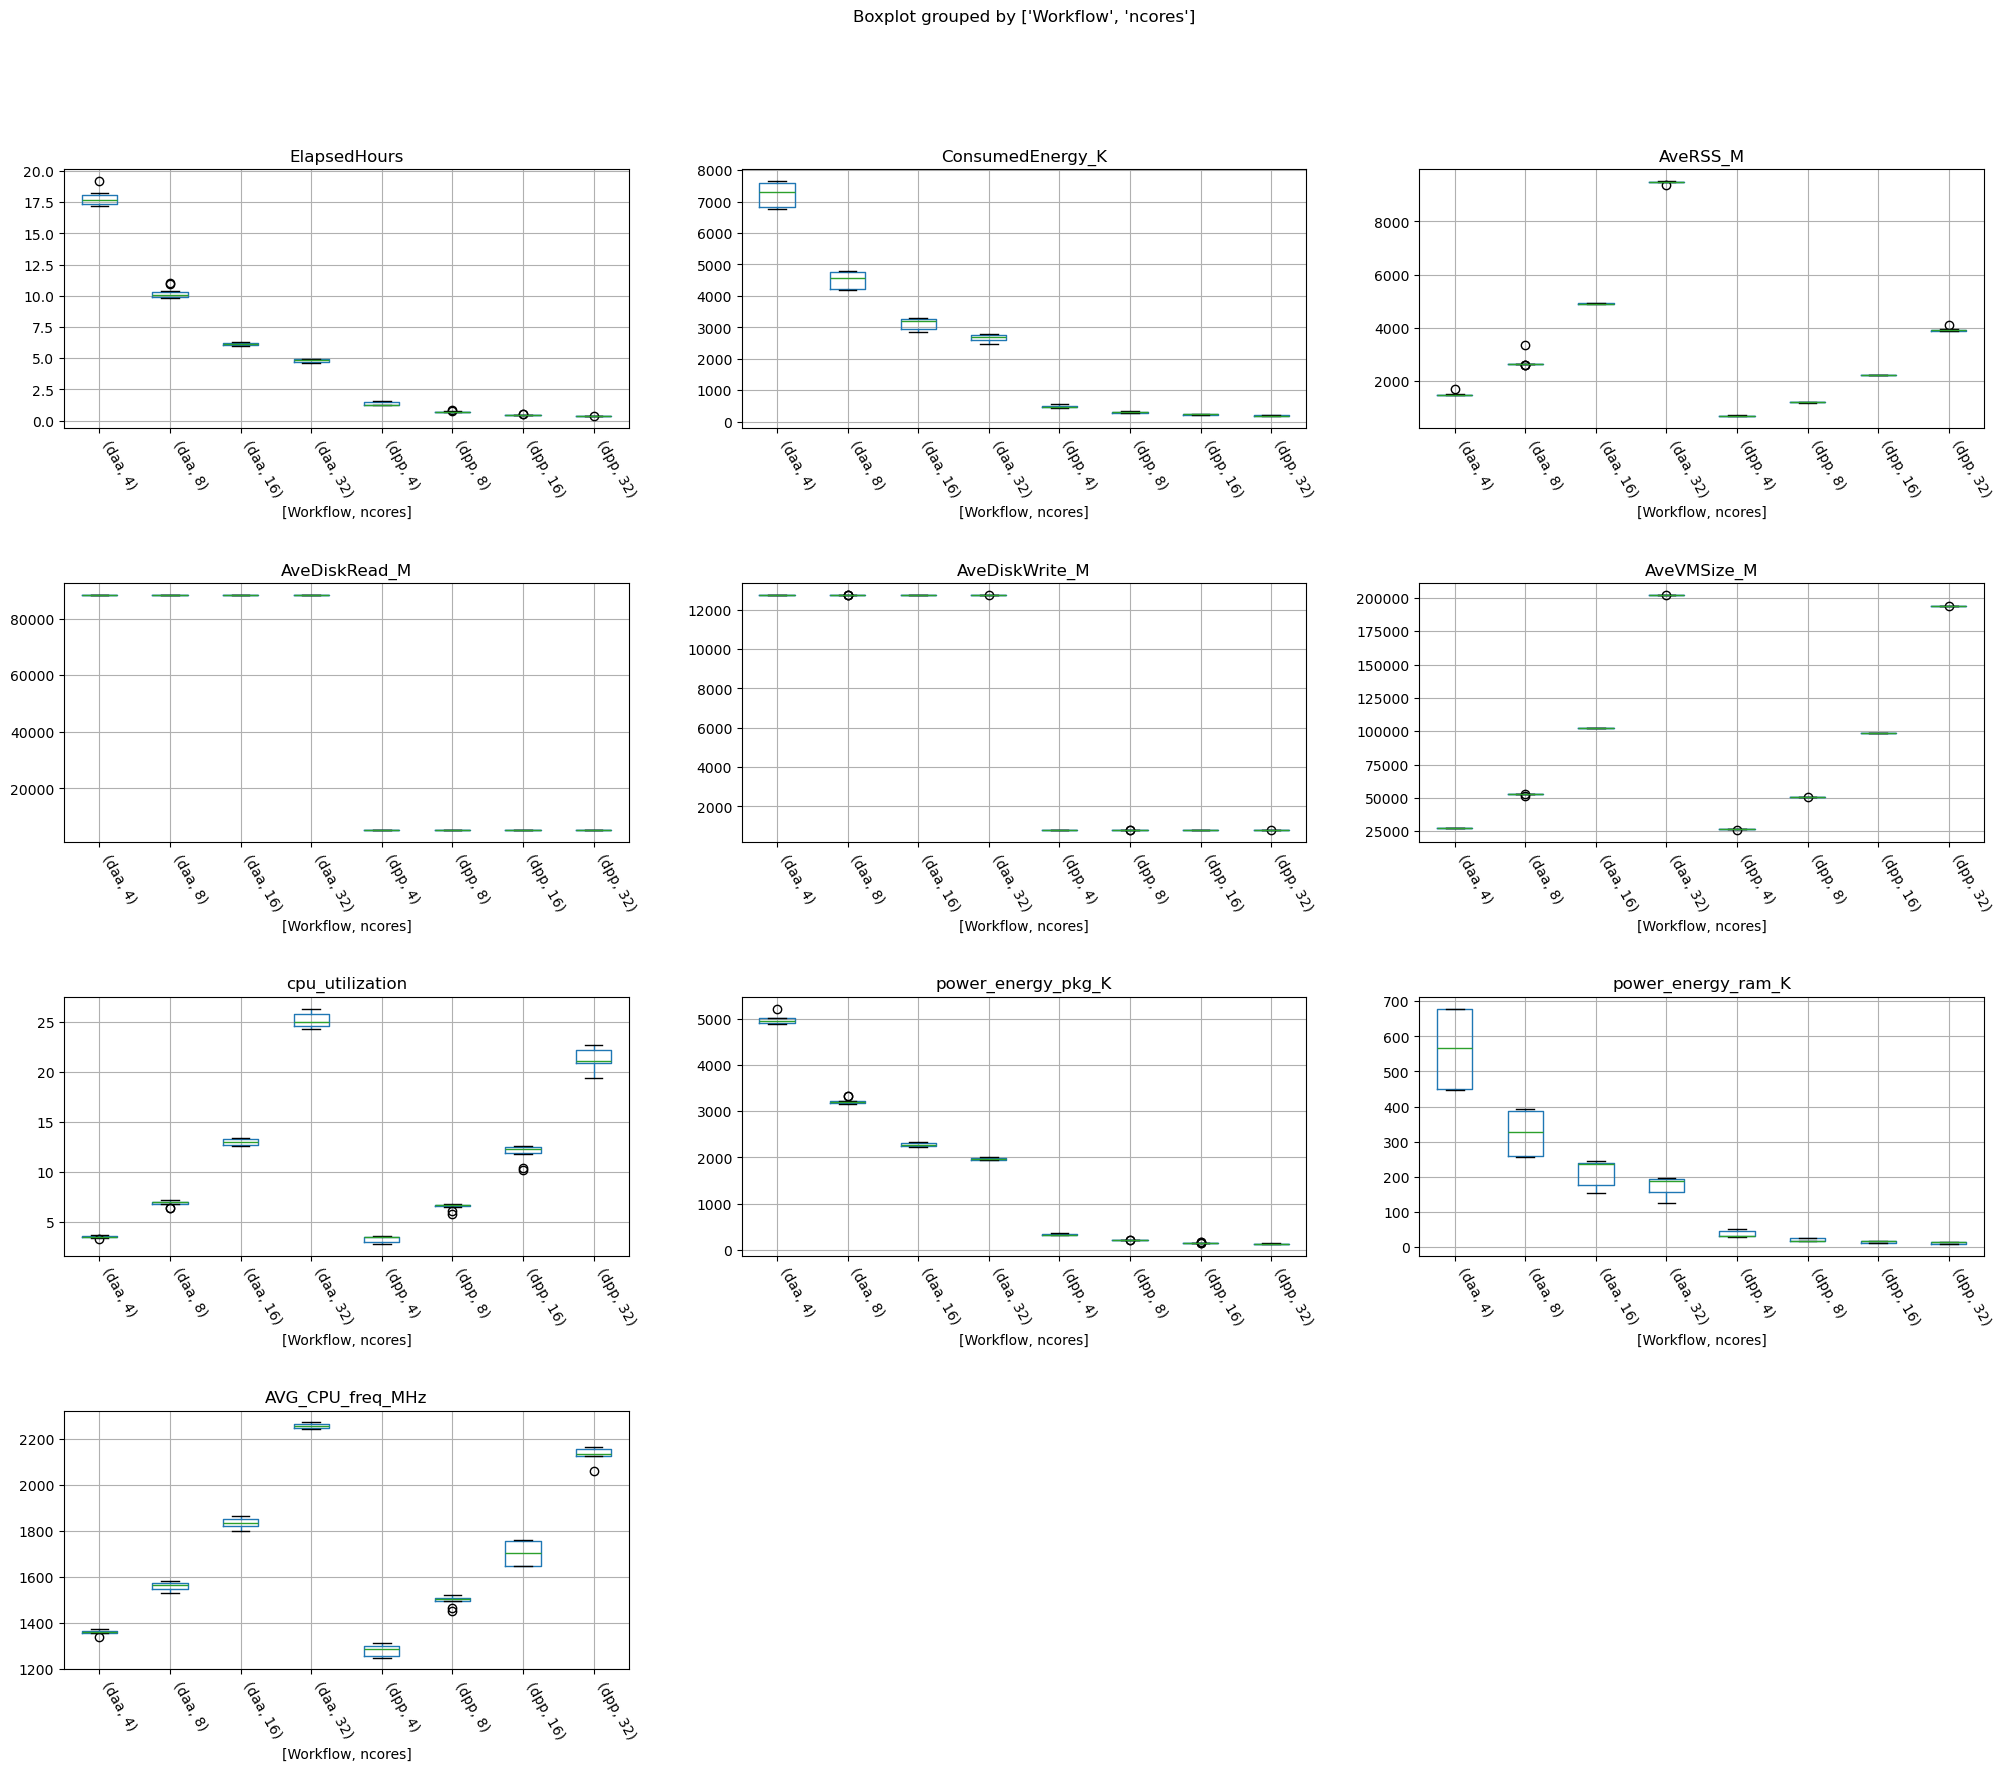

In [20]:
import math

ncols = 3
nrows = math.ceil(len(columns_to_plot) / ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 5))
for i, column in enumerate(
        columns_to_plot):
    data_for_analysis.dropna(subset=column).boxplot(column=column, by=['Workflow', 'ncores'],
                                                    ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60, ha="left")

if len(columns_to_plot) < ncols * nrows:
    for i in range(len(columns_to_plot), ncols * nrows):
        ax[i // 3, i % 3].axis('off')

fig.subplots_adjust(hspace=0.6)

fig.savefig('boxplot-overview.no-nodes.png')